In [66]:
from ast import Str
from dataclasses import dataclass
from typing import List
import random
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [94]:
N_particles = 1000

@dataclass
class KineticScheme:
    x: List[float]
    state_dir: List[int]
    retro_dwell_time: List[int]
    antero_dwell_time: List[int] 
    pause_dwell_time: List[int]
    off_track_dwell_time: List[int]
    antero_run_length: List[float]
    retro_run_length: List[float]

def kinetic_schemes(
    kinetic_scheme: KineticScheme, 
    dt, velo_retro, velo_antero, params, n_particles, method):
    """
    Simulate the stochastic behavior of particles undergoing a four-state kinetic scheme.
    :param kinetic_scheme: instance of KineticScheme class containing particle states and positions
    :param dt: time step for simulation
    :param velo_retro: velocity of retrograde movement
    :param velo_antero: velocity of anterograde movement
    :param params: dictionary of transition rates and probabilities
    :param n_particles: number of particles to simulate
    :return: updated instance of KineticScheme class with simulated results
    """
    
    ## Transition Rates and Probability 
    gamma_01 = params['rate_ptm']
    gamma_10 = params['rate_mtp']
    gamma_ar = params['pr_atr']   
    gamma_ra = params['pr_rta']   
    gamma_off = params['pr_off']
    gamma_on = params['pr_on']

    # Calculate probabilities for each transition in the kinetic scheme

    p01 = gamma_01 * dt
    p10 = gamma_10 * dt
    p32 = gamma_10 * dt
    p23 = gamma_01 * dt
    p12 = gamma_ar * dt
    p21 = gamma_ra * dt
    p45 = p12
    p54 = p21
    poff = gamma_off * dt
    pon = gamma_on * dt

    if method == 'four_state':
        for i in range(0, n_particles):
            # Generate a random number between 0 and 1 to determine if a transition occurs
            z = random.random()
            
            # Particle is in state 0 (anterograde movement)
            if kinetic_scheme.state_dir[i] == 0:
                if z < p01:
                    kinetic_scheme.state_dir[i] = 1 # transition to state 1 (pause)    
            # Particle is in state 1 (pause)      
            elif kinetic_scheme.state_dir[i] == 1:
                if z < p12:
                    kinetic_scheme.state_dir[i] = 2 # transition to state 2 (pause)
                elif p12 <= z < (p12 + p10):
                    kinetic_scheme.state_dir[i] = 0 # transition to state 0 (anterograde movement)
            elif kinetic_scheme.state_dir[i] == 2:
                if z < p23:
                    kinetic_scheme.state_dir[i] = 3 # transition to state 3 (retrograde movement)
                elif p23 <= z < (p23 + p21):
                    kinetic_scheme.state_dir[i] = 1
            elif kinetic_scheme.state_dir[i] == 3: # transition to state 1 (pause)
                if z < p32:
                    kinetic_scheme.state_dir[i] = 2  # transition to state 2 (pause)
            # Update the particle's position and dwell times based on its current state    
            if kinetic_scheme.state_dir[i] == 0:
                x_old = kinetic_scheme.x[i]
                kinetic_scheme.x[i] += velo_antero * dt
                x_update = kinetic_scheme.x[i]
                kinetic_scheme.antero_dwell_time[i] += 1
                kinetic_scheme.antero_run_length[i] += x_update - x_old
            elif kinetic_scheme.state_dir[i] == 1:
                # x[i] = x[i]
                kinetic_scheme.pause_dwell_time[i] += 1
            elif kinetic_scheme.state_dir[i] == 2:
                # x[i] = x[i]
                kinetic_scheme.pause_dwell_time[i] += 1
            elif kinetic_scheme.state_dir[i] == 3:
                x_old = kinetic_scheme.x[i]
                kinetic_scheme.x[i] += velo_retro * dt
                x_update = kinetic_scheme.x[i]
                kinetic_scheme.retro_dwell_time[i] += 1
                kinetic_scheme.retro_run_length[i] += x_update - x_old

    elif method=='six_state':
        for i in range(0, n_particles):
            z = random.random()
            if kinetic_scheme.state_dir[i] == 0:
                if z < p01:
                    kinetic_scheme.state_dir[i] = 1
            elif kinetic_scheme.state_dir[i] == 1:
                if z < p12:
                    kinetic_scheme.state_dir[i] = 2
                elif p12 <= z < (p12 + p10):
                    kinetic_scheme.state_dir[i] = 0
                elif (p12 + p10) <= z < (p12 + p10 + poff):
                    kinetic_scheme.state_dir[i] = 4 #transition to state 4 (off)
            elif kinetic_scheme.state_dir[i] == 2:
                if z < p23:
                    kinetic_scheme.state_dir[i] = 3
                elif p23 <= z < (p23 + p21):
                    kinetic_scheme.state_dir[i] = 1
                elif (p23 + p21) <= z < (p23 + p21 + poff):
                    kinetic_scheme.state_dir[i] = 5 #transition to state 5 (on)
            elif kinetic_scheme.state_dir[i] == 3:
                if z < p32:
                    kinetic_scheme.state_dir[i] = 2
            elif kinetic_scheme.state_dir[i] == 4:
                if z < pon:
                    kinetic_scheme.state_dir[i] = 1
                elif pon <= z < (pon + p45):
                    kinetic_scheme.state_dir[i] = 5 #transition to state 5 (on)
            elif kinetic_scheme.state_dir[i] == 5:
                if z < pon:
                    kinetic_scheme.state_dir[i] = 2
                elif pon <= z < (pon + p54):
                    kinetic_scheme.state_dir[i] = 4 #transition to state 4 (off)


            if kinetic_scheme.state_dir[i] == 0:
                x_old = kinetic_scheme.x[i]
                kinetic_scheme.x[i] += velo_antero * dt
                x_update = kinetic_scheme.x[i]
                kinetic_scheme.antero_dwell_time[i] += 1
                kinetic_scheme.antero_run_length[i] += x_update - x_old
            elif kinetic_scheme.state_dir[i] == 1:
                # x[i] = x[i]
                kinetic_scheme.pause_dwell_time[i] += 1
            elif kinetic_scheme.state_dir[i] == 2:
                # x[i] = x[i]
                kinetic_scheme.pause_dwell_time[i] += 1
            elif kinetic_scheme.state_dir[i] == 3:
                x_old = kinetic_scheme.x[i]
                kinetic_scheme.x[i] += velo_retro * dt
                x_update = kinetic_scheme.x[i]
                kinetic_scheme.retro_dwell_time[i] += 1
                kinetic_scheme.retro_run_length[i] += x_update - x_old
            elif kinetic_scheme.state_dir[i] in [4, 5]:
                kinetic_scheme.off_track_dwell_time[i] += 1

    return kinetic_scheme



def movements(motion_of_kymograph):
    pr_mtm = 0
    pr_ptm = 0
    pr_ptp = 0  
    pr_mtp = 0
    num_particles = 0

    for col in movements.columns:
        move_to_move = 0
        move_to_pause = 0
        pause_to_move = 0
        pause_to_pause = 0
        
        temp_movements = movements[~movements[col].isna()].reindex()

        for row in temp_movements.index:
            if row == len(temp_movements):
                continue
            else:
                if temp_movements.loc[row, col] == 1 and temp_movements.loc[row+1, col] == 1:
                    move_to_move += 1
                elif temp_movements.loc[row, col] == 0 and temp_movements.loc[row+1, col] == 0:
                    pause_to_pause +=1
                elif temp_movements.loc[row+1, col] - temp_movements.loc[row, col] > 0:
                    pause_to_move += 1
                elif temp_movements.loc[row+1, col] - temp_movements.loc[row, col] < 0:
                    move_to_pause += 1
        
        total_transitions = move_to_move + pause_to_pause + pause_to_move + move_to_pause
        try:
            pr_mtm += move_to_move/total_transitions
            pr_ptm += pause_to_move/total_transitions
            pr_ptp += pause_to_pause/total_transitions
            pr_mtp += move_to_pause/total_transitions
        except ZeroDivisionError:
            continue
            
        num_particles += 1
    return {
        "pr_mtm": pr_mtm/num_particles,
        "pr_ptm": pr_ptm/num_particles,
        "pr_ptp": pr_ptp/num_particles,
        "pr_mtp": pr_mtp/num_particles
    }

def transition_rates_for_directions(movements):
    """
    Calculates the probability of a particle transitioning between four different states (move-to-move, 
    pause-to-move, pause-to-pause, and move-to-pause) based on its movements along the kymograph. 
    
    Parameters:
    movements: A dataframe of kymograph data, where each column represents a particle and 
    each row represents a time point. The values in the dataframe indicate the particle's movement direction 
    at a given time point (-1 for retrograde, 0 for stationary, 1 for anterograde).
    
    Returns:
    Transition probabilities for each of the four states.
    """
    
    pr_atr = 0
    pr_rta = 0
    num_particles = 0
    
    for col in movements.columns:
        retro_to_antero = 0
        antero_to_retro = 0

        temp_movements = movements[~movements[col].isna()]

        for row in temp_movements.index:
            if row==1 or row >= len(temp_movements)-3:
                continue
            else:
                if temp_movements.loc[row, col] == -1 and temp_movements.loc[row+1, col] == 0 and \
                    temp_movements.loc[row+2, col] == 0 and temp_movements.loc[row+3, col] == 1:
                    retro_to_antero += 1
                elif temp_movements.loc[row, col] == 1 and temp_movements.loc[row+1, col] == 0 and \
                        temp_movements.loc[row+2, col] == 0 and temp_movements.loc[row+3, col] == -1:
                    antero_to_retro +=1

        total_transitions = antero_to_retro + antero_to_retro

        try:
            pr_rta += retro_to_antero/total_transitions
            pr_atr += antero_to_retro/total_transitions
        except ZeroDivisionError:
            continue

        num_particles += 1

    return {
        "pr_atr": pr_atr/num_particles,
        "pr_rta": pr_rta/num_particles   
    }

def format_summary_report(summary):
    # aasign -1.0 to retrograde motion and 1.0 to anterograde motion
    summary['direction'] = summary.Direction.map({-1: 'retrograde', 1: 'anterograde'})
    summary['track total displacement [um]'] = summary['track total displacement [um]']*summary['Direction']

def summary_histogram(summary):

    sb.histplot(data=summary, x='track total displacement [um]', stat='count', bins='auto', binwidth=10,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None)
    plt.show()


def get_movement_from_track_cordinate(track_cord):
    track_cord.drop(columns=[f't [pixel] #{col}' for col in range(1, 36)], inplace=True)
    return track_cord.diff(axis=0)

def get_rates(motion):
    pr_ptm = motion["pr_ptm"]
    pr_mtp = motion["pr_mtp"]
    return {
        "rate_ptm": -1 * pr_ptm/(pr_ptm + pr_mtp) * np.log(1 - pr_ptm - pr_mtp),
        "rate_mtp": -1 * pr_mtp/(pr_ptm + pr_mtp) * np.log(1 - pr_ptm - pr_mtp)
    }

def frame_2_frame_velocity_plots(summary):
     # get the mean of the average frame to frame velocity           
    sb.barplot(data=summary, x="Av frame2frame velocity [um/sec]", y="direction")
    plt.show()


def sim_exp_comparison(summary, summary_test):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sb.histplot(data=summary_test, x='track total displacement [um]', stat='count', bins='auto', binwidth=5,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[0])
    axs[0].set_title('Simulation', fontsize=20)
    sb.histplot(data=summary, x='track total displacement [um]', stat='count', bins='auto', binwidth=5,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[1])
    axs[1].set_title('Experiment', fontsize=20)
    plt.show()


def dwell_times(summary_test, method, dt):

    if method=='six_state':
        fig, axs = plt.subplots(1, 4, figsize=(14, 6))
    elif method=='four_state':
        fig, axs = plt.subplots(1, 3, figsize=(14, 6))

    sb.histplot(data=summary_test, x='antero_dwell_time', stat='count', bins='auto', binwidth=dt,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[0])
    axs[0].set_title('Anterograde Dwell Time', fontsize=15)

    sb.histplot(data=summary_test, x='retro_dwell_time', stat='count', bins='auto', binwidth=dt,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[1])
    axs[1].set_title('Retrograde Dwell Time', fontsize=15)

    sb.histplot(data=summary_test, x='pause_dwell_time', stat='count', bins='auto', binwidth=dt,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[2])
    axs[2].set_title('Pause Dwell Time', fontsize=15)


    if method=='six_state':
        summary_test = summary_test[summary_test.off_track_dwell_time!=0]
        sb.histplot(data=summary_test, x='off_track_dwell_time', stat='count', bins='auto', binwidth=dt,
                    hue='direction',
                        binrange=None,discrete=None, cumulative=False, common_bins=True,
                        common_norm=True, multiple='layer', element='bars',
                        fill=True, shrink=1, kde=False, kde_kws=None,
                        line_kws=None, thresh=0, pthresh=None, pmax=None,
                        cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                        hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[3])
        axs[3].set_title('Off Track Dwell Time', fontsize=15)

    plt.suptitle('Simulation', fontsize=25)
    plt.show()


def run_lengths(summary_test, dt):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sb.histplot(data=summary_test, x='antero_run_length', stat='count', bins='auto', binwidth=dt,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[0])
    axs[0].set_title('Anterograde Run Length', fontsize=20)

    sb.histplot(data=summary_test, x='retro_run_length', stat='count', bins='auto', binwidth=dt,
                hue='direction',
                    binrange=None,discrete=None, cumulative=False, common_bins=True,
                    common_norm=True, multiple='layer', element='bars',
                    fill=True, shrink=1, kde=False, kde_kws=None,
                    line_kws=None, thresh=0, pthresh=None, pmax=None,
                    cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                    hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[1])
    axs[1].set_title('Retrograde Run Length', fontsize=20)

    plt.suptitle('Simulation', fontsize=25)
    plt.show()




def build_summary_test(kinetic_scheme: KineticScheme, position, method):
    summary_test = pd.DataFrame()
    summary_test['track total displacement [um]'] = None
    summary_test['track total displacement [um]'] = list(position[-1, :] - position[0, :])
    summary_test['direction'] = summary_test.applymap(lambda x: 'anterograde' if x>0 else 'retrograde', na_action='ignore')
    summary_test['antero_dwell_time'] = kinetic_scheme.antero_dwell_time
    summary_test['retro_dwell_time'] = kinetic_scheme.retro_dwell_time
    summary_test['pause_dwell_time'] = kinetic_scheme.pause_dwell_time
    if method == 'six_state':
        summary_test['off_track_dwell_time'] = kinetic_scheme.off_track_dwell_time    
    summary_test['antero_run_length'] = kinetic_scheme.antero_run_length
    summary_test['retro_run_length'] = kinetic_scheme.retro_run_length
    return summary_test


def visualize_particles(t, n_particles, position):
    fig, axs = plt.subplots()
    for particle in range(n_particles):
        axs.plot(t, position[:, particle])
    plt.show()


def get_positions(t, dt, position, n_particles, params, kinetic_scheme, velo_antero, velo_retro, method='four_state'):
    for ind, time in enumerate(t[1:]):
        kinetic_scheme = kinetic_schemes(
            kinetic_scheme = kinetic_scheme, 
            dt=dt,
            velo_antero=velo_antero,
            velo_retro=velo_retro,
            n_particles=n_particles,
            params=params, 
            method=method)
        position[ind+1, :] = kinetic_scheme.x
        
    return

   

def track_total_displacement(summary):
    sb.histplot(data=summary, x='track total displacement [um]', stat='count', bins='auto', binwidth=10,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None)
    plt.show()
    
def run_full_project(track_cordinate_source: Str, summary_source: Str):
    # import track coordinates
    track_cord = pd.read_csv(track_cordinate_source)

    summary = pd.read_csv(summary_source, skiprows=1, index_col=False)
    format_summary_report(summary)
    
    track_total_displacement(summary)

    track_diff = get_movement_from_track_cordinate(track_cord)
    directional_movements = track_diff.applymap(lambda x: 1 if x > 0 else (-1 if x < 0 else 0), na_action='ignore')
    movements = track_diff.applymap(lambda x: 1 if x!=0 else 0, na_action='ignore')

    # kymograph motion 
    kymograph_motion = motion_of_kymograph(movements)


    frame_2_frame_velocity_plots(summary)
      
    init_position = list(np.random.randint(100, high=300, size=N_particles, dtype=int))

    params = get_rates(kymograph_motion)
    params.update(transition_rates_for_directions(directional_movements))
    params['pr_off'] = 4.45E-03
    params['pr_on']  = 2.75E-04

    kinetic_scheme = KineticScheme(
        x = np.zeros((N_particles)) + init_position,
        state_dir=np.zeros((N_particles)),
        retro_dwell_time=np.zeros((N_particles)),
        antero_dwell_time=np.zeros((N_particles)),
        pause_dwell_time=np.zeros((N_particles)),
        off_track_dwell_time=np.zeros((N_particles)),
        antero_run_length=np.zeros((N_particles)),
        retro_run_length=np.zeros((N_particles)),
        )
    dt = 1
    t = np.arange(1, 181, dt)
    #total_count = retro_count + antero_count + pause_count
    velo_antero = summary[summary.direction=='anterograde']['Av frame2frame velocity [um/sec]'].mean()
    #velo_retro = -1*retro_count/total_count
    velo_retro = -1*summary[summary.direction=='retrograde']['Av frame2frame velocity [um/sec]'].mean()
    position = np.zeros((len(t), N_particles)) + init_position
    method = 'six_state' # specify the model to be used
    get_positions(t, dt, position , N_particles, params, kinetic_scheme, velo_antero, velo_retro, method)

    visualize_particles(t, N_particles, position)
    summary_test = build_summary_test(kinetic_scheme, position, method)

    sim_exp_comparison(summary, summary_test)
    dwell_times(summary_test, method, dt)
    run_lengths(summary_test, dt)

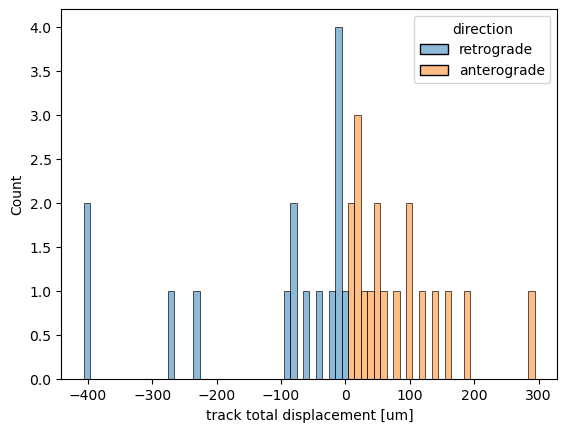

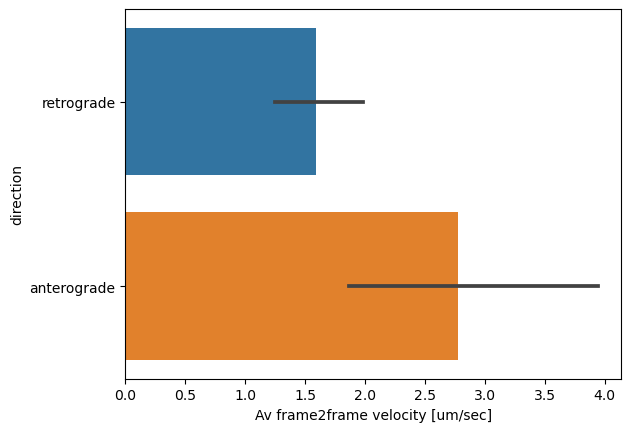

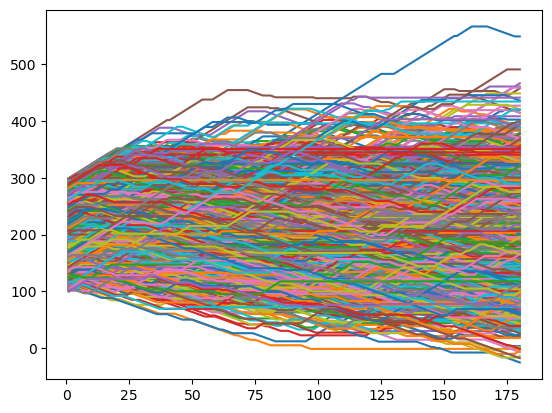

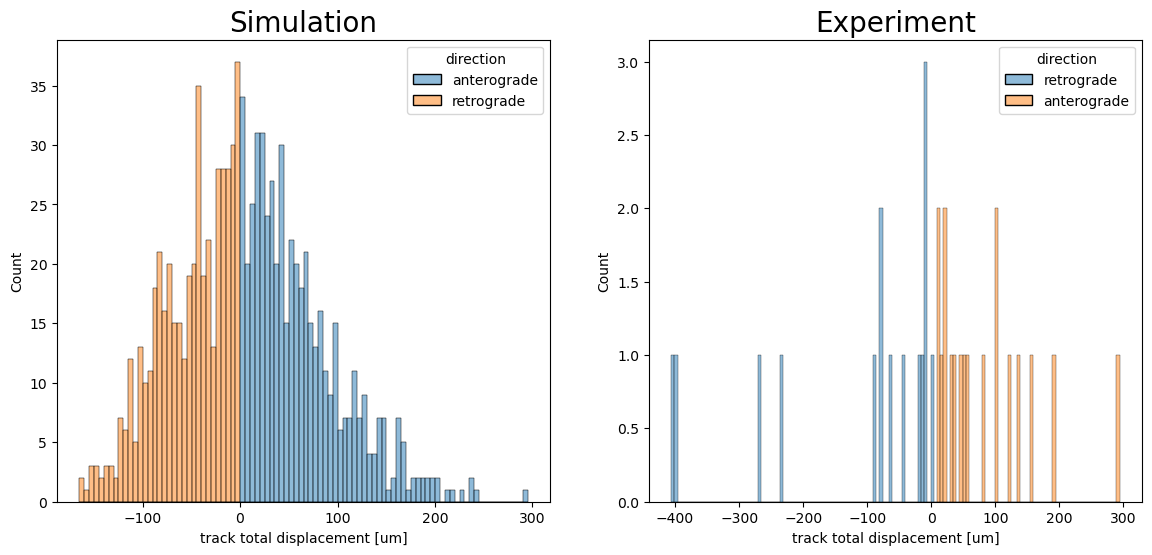

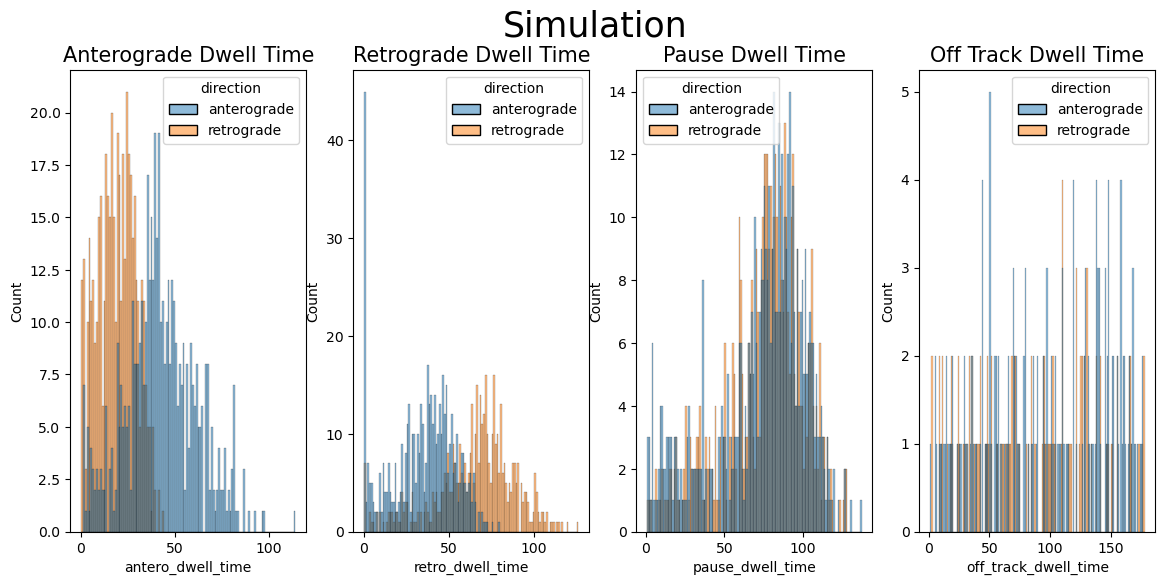

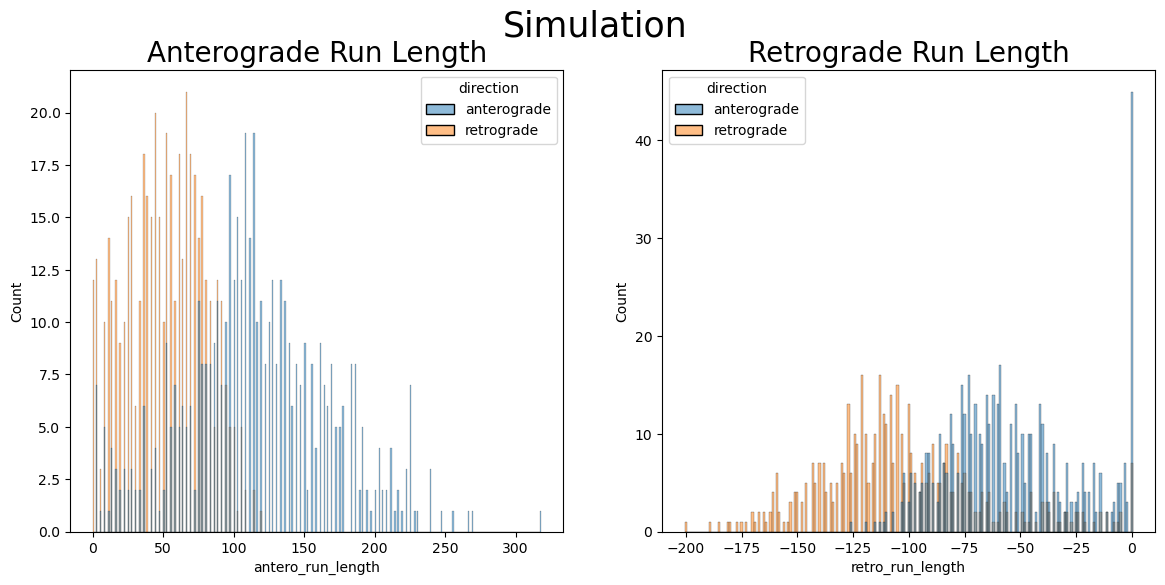

In [95]:
run_full_project('web_results/trackCoordinates.csv', 'web_results/summary.csv')